# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## 1. Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats as st

calls = pd.read_csv('datasets/tariffs/calls.csv')
internet = pd.read_csv('datasets/tariffs/internet.csv', index_col=0)
messages = pd.read_csv('datasets/tariffs/messages.csv')
tariffs = pd.read_csv('datasets/tariffs/tariffs.csv')
users = pd.read_csv('datasets/tariffs/users.csv')

In [2]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [3]:
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
#провека на дубликаты. Начало
print(users[users.duplicated()]['user_id'].count()) 
print(messages[messages.duplicated()]['id'].count()) 
print(internet[internet.duplicated()]['id'].count()) 
print(calls[calls.duplicated()]['id'].count())
#провека на дубликаты. Конец

0
0
0
0


Видно множество колонок с датами, не приведенных к нужному формату, но вцелом датафреймы очень чистые, 
без nan значений (если не брать в расчёт колонку churn_date). Проверку на дубликаты датафреймы также прошли успешно

## 2. Подготовка данных

###  2.1 Подготовка данных

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y.%m.%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y.%m.%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y.%m.%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y.%m.%d')

Приводим колонки 'churn_date', 'call_date', 'reg_date', 'message_date' и 'session_date' к формату '%Y.%m.%d' методом to_datetime()

###  2.2 Звонки и минуты

In [9]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['month'] = calls['call_date'].dt.month
data_1 = calls.groupby(['user_id','month']).agg({'id':'count', 'duration': 'sum'}).reset_index().rename(columns={'id':'calls', 'duration': 'minutes'})
print(data_1)

      user_id  month  calls  minutes
0        1000      5     22    159.0
1        1000      6     43    172.0
2        1000      7     47    340.0
3        1000      8     52    408.0
4        1000      9     58    466.0
...       ...    ...    ...      ...
3169     1498     10     41    247.0
3170     1499      9      9     70.0
3171     1499     10     68    449.0
3172     1499     11     74    612.0
3173     1499     12     69    492.0

[3174 rows x 4 columns]


Создаем колонку с месяцами. В data_1 записываем датафрейм с количеством звонком и суммой минут за каждый месяц, подсчитанных методом groupby()

###  2.3 Сообщения

In [10]:
messages['month'] = messages['message_date'].dt.month
data_2 = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index().rename(columns={'id':'messages'})
print(data_2)

      user_id  month  messages
0        1000      5        22
1        1000      6        60
2        1000      7        75
3        1000      8        81
4        1000      9        57
...       ...    ...       ...
2712     1498     10        42
2713     1499      9        11
2714     1499     10        48
2715     1499     11        59
2716     1499     12        66

[2717 rows x 3 columns]


Создаем колонку с месяцами. В data_2 записываем датафрейм с количеством сообщений за каждый месяц, подсчитанных методом groupby()

###  2.4 Интернет

In [11]:
internet['month'] = internet['session_date'].dt.month
data_3 = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index().rename(columns={'mb_used':'internet'})
data_3['internet'] = data_3['internet']/1024
data_4 = pd.merge(data_1, data_2, how='outer', on=['user_id', 'month'])
data_5 = pd.merge(data_4, data_3, how='outer', on=['user_id', 'month'])
data_6 = pd.merge(users, data_5, how='outer', on=['user_id'])
data_6.head()
data_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3216 non-null   int64         
 1   age         3216 non-null   int64         
 2   churn_date  189 non-null    datetime64[ns]
 3   city        3216 non-null   object        
 4   first_name  3216 non-null   object        
 5   last_name   3216 non-null   object        
 6   reg_date    3216 non-null   datetime64[ns]
 7   tariff      3216 non-null   object        
 8   month       3214 non-null   float64       
 9   calls       3174 non-null   float64       
 10  minutes     3174 non-null   float64       
 11  messages    2717 non-null   float64       
 12  internet    3203 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 351.8+ KB


Создаем колонку с месяцами. В data_3 записываем датафрейм с использованным интернет-трафиком за каждый месяц, подсчитанных методом groupby(). Далее методом merge() склеиваем полученные датафреймы в одну единую таблицу(data_6). Используя метод join() код получился бы более опрятный, но у меня не получилось присоединить таблицы как следует через join(). Буду признателен если поможете с этим.

In [12]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'}, errors="raise")
data = pd.merge(data_6, tariffs, how="outer", on=["tariff"])
np.ceil(data['minutes'])
data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls,minutes,messages,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,2.200674,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,22.689229,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,13.675430,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,13.726494,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,14.227451,1000,30720,3000,1950,150,1,1


В таблице tariffs переименовываем колонку 'tariff_name' в 'tariff' для последующего склеивания с таблицей data_6. После создания финального датафрейма (data) округляем значения в колонках 'minutes', 'messages' и 'internet' в большую сторону методом ceil().

###  2.5 Помесячная выручка с каждого пользователя

In [13]:
data['minutes_remain'] = data['minutes'] - data['minutes_included']
data['messages_remain'] = data['messages'] - data['messages_included']
data['internet_remain'] = (data['internet'] - (data['mb_per_month_included']/1024)).apply(np.ceil)

data.loc[:, 'total'] = 0
data.loc[(data['messages_remain'] > 0), 'total'] = data['messages_remain'] * data['rub_per_message'] 
data.loc[(data['minutes_remain'] > 0), 'total'] += data['minutes_remain'] * data['rub_per_minute']
data.loc[(data['internet_remain'] > 0), 'total'] += data['internet_remain'] * data['rub_per_gb']
data['total'] += data['rub_monthly_fee']

data['total'] = data['total'].astype('int')
data.loc[:, 'tariff':]

,tariff,month,calls,minutes,messages,internet,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_remain,messages_remain,internet_remain,total
0,ultra,5.0,22.0,159.0,22.0,2.200674,1000,30720,3000,1950,150,1,1,-2841.0,-978.0,-27.0,1950
1,ultra,6.0,43.0,172.0,60.0,22.689229,1000,30720,3000,1950,150,1,1,-2828.0,-940.0,-7.0,1950
2,ultra,7.0,47.0,340.0,75.0,13.675430,1000,30720,3000,1950,150,1,1,-2660.0,-925.0,-16.0,1950
3,ultra,8.0,52.0,408.0,81.0,13.726494,1000,30720,3000,1950,150,1,1,-2592.0,-919.0,-16.0,1950
4,ultra,9.0,58.0,466.0,57.0,14.227451,1000,30720,3000,1950,150,1,1,-2534.0,-943.0,-15.0,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,smart,10.0,41.0,247.0,42.0,20.097031,50,15360,500,550,200,3,3,-253.0,-8.0,6.0,1750
3212,smart,9.0,9.0,70.0,11.0,1.802490,50,15360,500,550,200,3,3,-430.0,-39.0,-13.0,550
3213,smart,10.0,68.0,449.0,48.0,17.371592,50,15360,500,550,200,3,3,-51.0,-2.0,3.0,1150
3214,smart,11.0,74.0,612.0,59.0,17.542295,50,15360,500,550,200,3,3,112.0,9.0,3.0,1513


Пошагово высчитываем помесячную выручку с каждого пользователя. Для начала вычитаем из данных включенные в тариф минуты, сообщения и интернет-трафик. Затем создаем колонку 'total' с нулевыми значениями. После положительные остатки умножаются на стоимость услуг сверх тарифного пакета. И в конце прибавляем абонентскую плату, соответствующую тарифному плану. Также переводим столбец 'total' в более приятный целочисленный тип данных.

## 3. Анализ данных

In [14]:
mean = data.groupby(by = 'tariff').agg({'minutes':'mean', 'messages':'mean', 'internet':'mean'}).reset_index().round(1)
print('Среднее количество')
display(mean)

var = data.groupby(by = 'tariff').agg({'minutes':'var', 'messages':'var', 'internet':'var'}).reset_index().round(1)
print('Дисперсия')
display(var)

std = data.groupby(by = 'tariff').agg({'minutes':'std', 'messages':'std', 'internet':'std'}).reset_index().round(1)
print('Стандартное отклонение')
display(std)

Среднее количество


,tariff,minutes,messages,internet
0,smart,419.1,38.7,15.8
1,ultra,545.5,61.2,19.2


Дисперсия


,tariff,minutes,messages,internet
0,smart,35844.2,717.6,32.8
1,ultra,94203.4,2109.7,94.3


Стандартное отклонение


,tariff,minutes,messages,internet
0,smart,189.3,26.8,5.7
1,ultra,306.9,45.9,9.7


В среднем пользователи тарифа Ультра используют больше минут, сообщений и ГБ интернета, чем пользователи тарифа Смарт. Но можно заметить интересную закономерность - из включенных в пакет услуг 500 минут пользователи тарифа Смарт используют в среднем около 419, из 50 сообщений 38 и из 15ГБ 16-17ГБ (то есть бóльшая часть пользователей доплачивает за доп. ГБ интернета). Как видно, пользователи тарифа Смарт тратят бóльшую часть пакета услуг. 

Теперь посмотрим на поведение пользователей тарифа Ультра. Из 3000 включенных минут они используют в среднем 545, из 1000 включенных сообщений они используют в среднем 61, а из 30ГБ интеренета только 20ГБ. То есть в среднем пользователи тарифа Ультра осваивают около 18% минут, 6% сообщений и 64% интернет-трафика, в то время как пользователи тарифа Смарт осваивают около 84% минут, 76% сообщений и >100% интернет-трафика. 

Из всего этого вытекает логичный вопрос - стоит ли пользователям переплачивать за тариф Ультра если можно взять тариф Смарт и немного доплатить за дополнительные минуты/сообщения/интернет-трафик?  

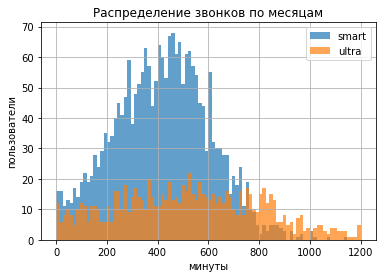

In [15]:
data[data['tariff'] == 'smart']['minutes'].hist(bins= 90, range = (0, 1200), legend = 'smart', alpha=0.7)
data[data['tariff'] == 'ultra']['minutes'].hist(bins= 90, range = (0, 1200), legend = 'ultra', alpha=0.7)
plt.ylabel('пользователи')
plt.xlabel('минуты')
plt.title('Распределение звонков по месяцам')
plt.legend(['smart', 'ultra']);

Большинство пользователей тратят 150-650 минут в месяц. Больше 800 минут за редким исключением тратят только пользователи тарифа Ультра.

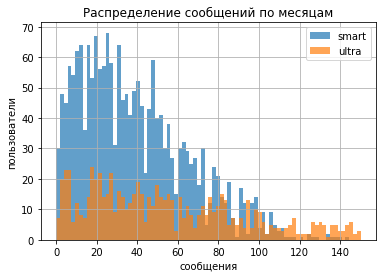

In [16]:
data[data['tariff'] == 'smart']['messages'].hist(bins= 80, range = (0, 150), alpha=0.7)
data[data['tariff'] == 'ultra']['messages'].hist(bins= 80, range = (0, 150), alpha=0.7)
plt.ylabel('пользователи')
plt.xlabel('сообщения')
plt.title('Распределение сообщений по месяцам')
plt.legend(['smart', 'ultra']);

Большинство пользователей тратят до 60 сообщений в месяц. Больше 100 сообщений отправляют преимущественно пользователи тарифа Ультра (с тарифом 1000 сообщений/месяц могут себе позволить)

58%
13%


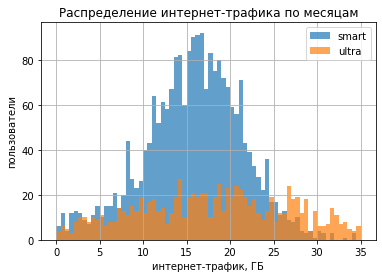

In [17]:
data[data['tariff'] == 'smart']['internet'].hist(bins= 70, range = (0, 35), alpha=0.7)
data[data['tariff'] == 'ultra']['internet'].hist(bins= 70, range = (0, 35), alpha=0.7)
plt.ylabel('пользователи')
plt.xlabel('интернет-трафик, ГБ')
plt.title('Распределение интернет-трафика по месяцам')
plt.legend(['smart', 'ultra']);

df_s = data[data['tariff'] == 'smart']
df_u = data[data['tariff'] == 'ultra']
print(int(df_s[df_s['internet'] > df_s['mb_per_month_included']/1024]['user_id'].count()/data[data['tariff'] == 'smart']['user_id'].count()*100),'%', sep='')
print(int(df_u[df_u['internet'] > df_u['mb_per_month_included']/1024]['user_id'].count()/data[data['tariff'] == 'ultra']['user_id'].count()*100),'%', sep='')

Большинство пользователей тратят 10-23ГБ интернет-трафика в месяц. Сверх этого тратят преимущественно только пользователи тарифа Ультра. Причем целых 13% не укладываются и в 30Гб, включенных в пакет услуг. Также можно подметить, что больше половины пользователей тарифа Смарт (58%) не укладывается в ежемесячный бесплатный лимит  

## 4. Проверка гипотез

### 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.

Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. 

p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу


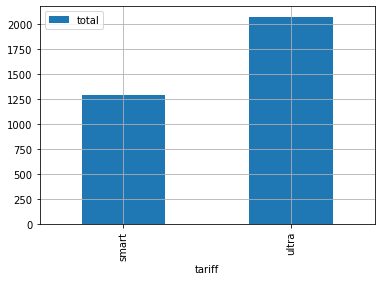

In [18]:
alpha = 0.05
ultra = data[data['tariff'] == 'ultra']['total']
smart = data[data['tariff'] == 'smart']['total']
results = st.ttest_ind(smart, ultra)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
data.groupby('tariff').agg({'total':'mean'}).plot(kind = 'bar', grid = True);    

Проверяем нулевую гипотезу используя ttest и строим график для наглядности. p-значение достаточно мало, значит мы можем отвергнуть нулевую гипотезу. Альтернативную гипотезу мы, напротив, принимаем как истинную. Средние выручки пользователей тарифов «Ультра» и «Смарт» и правда сильно различаются: выручка с пользователей тарифа "Смарт" составляет около 1290 рублей, в то время как пользователи тарифа "Ультра" в среднем платят по 2070 рублей.

### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 

Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


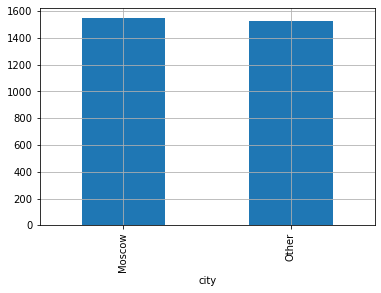

In [19]:
alpha = 0.05
moscow = data[data['city'] == 'Москва']['total']
other = data[data['city'] != 'Москва']['total']
results = st.ttest_ind(moscow, other)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
cities = pd.DataFrame({'city': ['Moscow', 'Other'], 'total_mean': 
                       [data[data['city'] == 'Москва']['total'].mean(), data[data['city'] != 'Москва']['total'].mean()]})
cities.plot(x='city', y='total_mean', kind = 'bar', grid = True, legend = False);    

Проверяем нулевую гипотезу используя ttest и строим график для наглядности. p-значение равно 0.54, значит нулевая гипотеза правдива. Средняя выручка с пользователей из Москвы равна выручке с пользователей из других регионов.

## 5. Общий вывод

In [25]:
print('Всего пользователей тарифа Смарт: ', df_s['user_id'].nunique())
print('Всего пользователей тарифа Ультра:', df_u['user_id'].nunique())
print('Пользователей тарифа Смарт больше, чем пользователей тарифа Ультра в', round((df_s['user_id'].nunique()/df_u['user_id'].nunique()), 2), 'раза\n')
print('Вся выручка с пользователей тарифа Смарт: ', df_s['total'].sum())
print('Вся выручка с пользователей тарифа Ультра:', df_u['total'].sum())
print('Выручка с тарифа Смарт больше выручки с тарифа Ультра на ', round((df_s['total'].sum()/df_u['total'].sum()-1)*100),'%', sep='')

Всего пользователей тарифа Смарт:  351
Всего пользователей тарифа Ультра: 149
Пользователей тарифа Смарт больше, чем пользователей тарифа Ультра в 2.36 раза

Вся выручка с пользователей тарифа Смарт:  2875901
Вся выручка с пользователей тарифа Ультра: 2041050
Выручка с тарифа Смарт больше выручки с тарифа Ультра на 41%


Был проведен анализ данных по двум тарифам с разной ежемесячной платой и тарифными планами. Выбрать, на какой тариф лучше направить рекламный бюджет непросто, но всё же я попробую сделать это и обосновать своё решение.

Из проведенных ранее исследований следует, что средняя ежемесячная выручка с пользователей тарифа "Смарт" составляет около 1290 рублей, в то время как пользователи тарифа "Ультра" в среднем платят по 2070 рублей. Также мы знаем, что выручка со всех пользователей тарифа Смарт равна 2.8млн, а со всех пользователей тарифа Ультра только 2млн. Но, учитывая, что пользователей тарифа Смарт в 2,36 раз больше, чем пользователей тарифа Ультра, а выручка больше только на 41% можно с уверенностью сказать, что при должной рекламной компании по привлечению большего количества новых клиентов с подключенным тарифом Ультра компания получит больше выручки. 

Однако наилучшим решением будет также направить хотя бы малую долю рекламного бюджета и на тариф Смарт, так как некоторых потенциальных клиентов может не устроить тариф Ультра, но тариф Смарт, напротив, будет полностью подходить им по всем критериям. На мой взгляд это поможет максимизировать выручку компании.